#### Data 620 - Project 2 <br>June 26, 2019<br>Team 2: <ul><li>Anthony Munoz</li> <li>Katie Evers</li> <li>Juliann McEachern</li> <li>Mia Siracusa</li></ul>

<h1 align="center">Network Analysis: 2-Mode Networks</h1>

## Project Overview

In a 2-node dataset, "there are two different types of nodes and links determine relationships between one set of nodes and the other (Tsvetovat & Kouznetsov 96)." We will be examining a data set inspired by the results of Project 1 network. In Project 1, we studied NYC OpenData's [Women Resources Network Database](https://data.cityofnewyork.us/Social-Services/NYC-Women-s-Resource-Network-Database/pqg4-dm6b) and examined connections as a singular network of organizations and boroughs with categorical feature attributes.

We choose to continue with this dataset and expand upon our basic network analysis as the NYC data source is extremely rich with categorical features. We are interested in seeing what new conclusions we can dervive from analyzing this network as a 2-mode, or bipartite, graph.  

#### Python Dependencies 

In [356]:
import pandas as pd, networkx as nx,matplotlib.pyplot as plt, numpy as np
from networkx.algorithms import bipartite

#### Data Transformations

In [363]:
#affiliation of directors to boards
net2m = pd.read_csv('http://www.boardsandgender.com/data/net2m/net2m_2011-07-01.txt', sep=" ", header=None)



In [327]:
# Read csv file from github
data = pd.read_csv('https://raw.githubusercontent.com/jemceach/620/master/Project-1/results.csv', index_col=0)

# define network groups
org =['organizationname']; boro=['bronx', 'brooklyn', 'manhattan', 'queens', 'staten_island']
services = ['aging', 'anti_discrimination_human_rights', 'arts_culture', 'child_care_parent_information', 'community_service_volunteerism', 'counseling_support_groups', 'disabilities', 'domestic_violence', 'education', 'employment_job_training', 'health', 'homelessness', 'housing', 'immigration', 'legal_services', 'lesbian_gay_bisexual_and_or_transgender', 'none_of_the_above', 'personal_finance_financial_education', 'veterans_military_families', 'victim_services', 'youth_services']
gov = ['new_york_city_agency','other_government_organization']

# Data transformations: transform dataframe from wide to long
t = data.reindex(org+boro+services+gov, axis=1).melt(id_vars=org+services+gov, value_vars=boro, var_name='borough').query("value == 'Y'").drop('value', axis=1).rename(columns={'organizationname': 'organization'})

# Combine government
def combine_gov(row):
    if row['new_york_city_agency'] == "Y":
        val = "1"
    elif row['other_government_organization'] == "Y":
        val = "1"
    else:
        val = "0"
    return val

t['government'] = t.apply(combine_gov, axis=1)

# create weights
t['weight'] = t.apply(lambda s: (s == "Y").sum(), axis=1)

data = t.reset_index().drop('index', axis=1).drop(services, axis=1).drop(gov, axis=1)

data.head()

,organization,borough,government,weight
0,RightRides for Women's Safety,bronx,0,3
1,American-Italian Cancer Foundation's Mobile Ma...,bronx,0,1
2,Legal Momentum,bronx,0,5
3,Young Mothers Program/BBBS,bronx,0,2
4,Federally Employed Women (FEW),bronx,0,3


# Biparthitie Graph

We will be examining the connection between boroughs and treating those as distinct groups, and the weight will be the count of categorical features of social services each organization provides. For example, an organization would have a weight of 3 if they provided 3 unique social services (i.e. veteran, homelessness, and disability related assistance).

#### Build Network

We built our network by looping through our dataset to add 2 sets of bipartite nodes. These nodes were added with the node attribute set to "bipartite". Edges were added only between nodes of opposite bipartite node sets.

In [348]:
## Ref: https://networkx.github.io/documentation/stable/reference/algorithms/bipartite.html

B = nx.Graph()

# add organization nodes as bipartite 0
for i in range(len(data)): 
    B.add_node(data.iloc[i][0],
                government=data.iloc[i][2],
                weight=data.iloc[i][3],
                bipartite=0)
    
# add borough nodes as bipartite 1
for i in range(len(data)): 
    B.add_node(data.iloc[i][1],
                bipartite=1)

# connect edges from both bipartite 0 and 1
for i in range(len(data)):
    B.add_edge(data.iloc[i][0], data.iloc[i][1], weight=1)

# identify top and bottom nodes
top_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}
bottom_nodes = set(B) - top_nodes

# verification
print("Verify graph is connected and bipartite:")
print("is_connected:",nx.is_connected(B),"\nis_bipartite:",nx.is_bipartite(B))


Verify graph is connected and bipartite:
is_connected: True 
is_bipartite: True


#### Examine Network

The output below highlights some basic features of our network.

In [329]:

print("\nNetwork",nx.info(G))

org_d = pd.DataFrame(G.degree(org_nodes)).sort_values(1,ascending =False).rename({0:'count',1:'degrees'}, axis=1).groupby('degrees')['count'].nunique()
print("\nOrganization nodes by", org_d)


Verify graph is connected and bipartite:
is_connected: True 
is_bipartite: True

Network Name: 
Type: Graph
Number of nodes: 1138
Number of edges: 1933
Average degree:   3.3972

Organization nodes by degrees
1    897
2     28
3     20
4     20
5    168
Name: count, dtype: int64


#### Visualize Network

In Project 1, we manually subsetted our nodes into their expected groupings - borough and organization - and individually set their node size accordingly. In using a 2-Mode-Network, we only had to add the nodes once 

C:\Users\15082\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


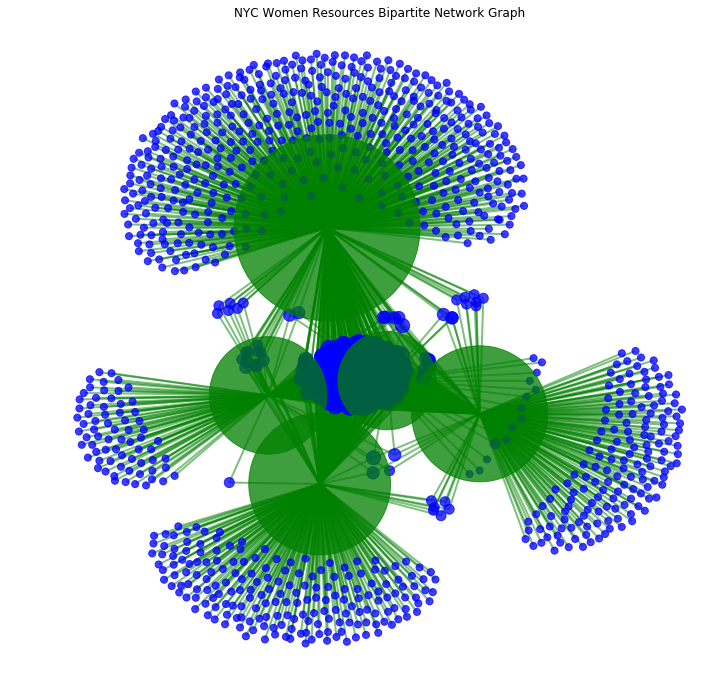

In [184]:
plt.figure(figsize=(12, 12))
           
# set layout position
pos=nx.spring_layout(G) 

colors=[]
for n in dict(G.degree()).keys():
    if n in dict(G.degree(org_nodes)).keys():
        if 
        colors.append('blue')
    else:
        colors.append('green')

# nodes
d = G.degree()
nx.draw_networkx_nodes(G,pos, node_color=colors, node_size=[v*50 for v in dict(d).values()], alpha=0.75)

# edges
nx.draw_networkx_edges(G,pos, width=2,alpha=0.5,edge_color='green',style='solid')

# labels
# nx.draw_networkx_labels(G, pos, font_size=8)

plt.axis('off')
plt.title('NYC Women Resources Bipartite Network Graph')
plt.show()

## Network Reduction

#### Island Method
The island method is a way to split up a large data set into smaller sections with more activity. These smaller sections can then be analyzed individually. Essentially, the large component is "flooded" and the valleys, or the areas data sets with the least edges, are submerged into water. The water, essentially a threshold on the edge values, thus breaks the large component into smaller pieces, or "islands".

We explored this technique using the island method as described in chapter 4 of our Social Network Analysis text.

In [226]:
## Implementing the Island Method to look for important subgroups. 
def trim_edges(g, weight = 1):
    # Implements a trimming of the graph edges for the Island Analysis
    g2 = nx.Graph()
    for u, v, c in g.edges(data=True):
        if c['weight'] > weight:
            g2.add_edge(u,v, weight=c)
    return g2


#return list of graphs each corresponding to different thresholds
def island_method(G, iterations=4):
    weights= [c['weight'] for u,v,c in G.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of step
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(G, threshold)] for threshold in range(mn,mx,step)]

#### Island Method on Organization Nodes

In [331]:
pc = nx.bipartite.weighted_projected_graph(G, G.nodes)
cc = list(nx.connected_component_subgraphs(pc))[0]
islands = island_method(cc, iterations = 4)

In [334]:
for i in islands:
    print(i[0], len(i[1]), len(list(nx.connected_component_subgraphs(i[1]))))

1 236 1
2 208 1
3 188 1
4 168 1


[2, <networkx.classes.graph.Graph at 0x1c0834a64e0>]

AttributeError: 'list' object has no attribute 'edges'

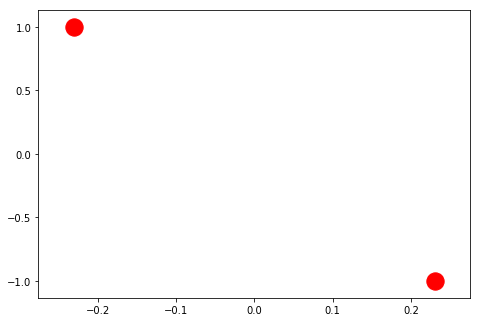

In [337]:
nx.draw(islands[3])

C:\Users\15082\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


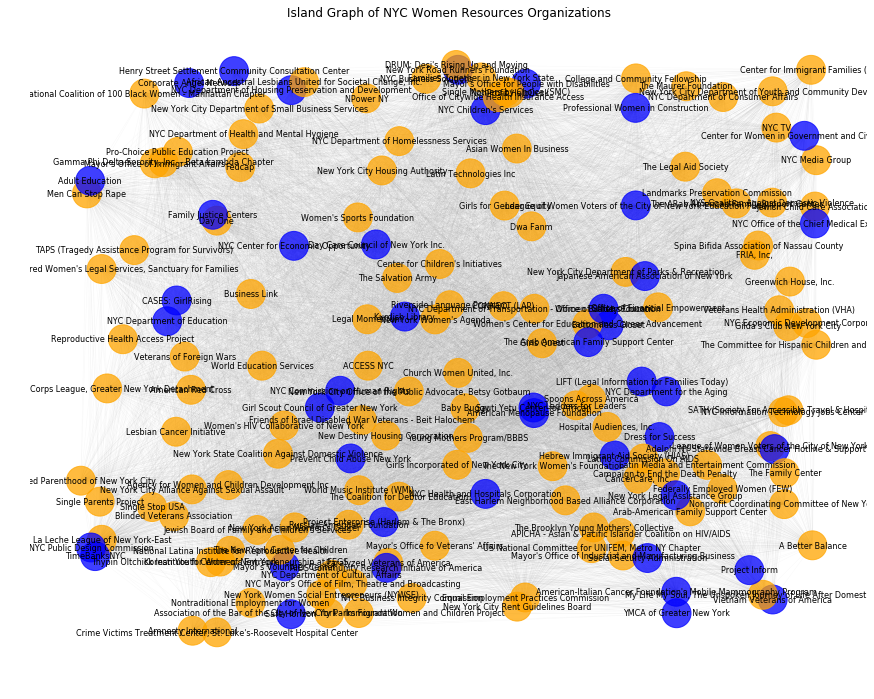

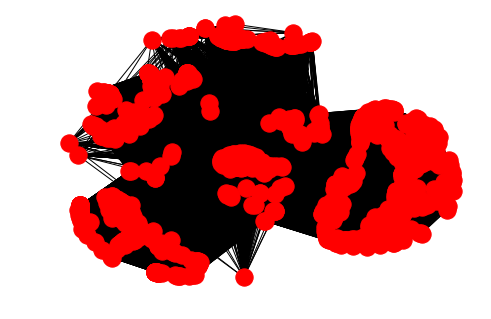

In [324]:
plt.figure(figsize=(15, 12))

pos = nx.random_layout(pc)

gov = set(data[data['government'] == "1"].iloc[:, 0].unique())
ngov = set(data[data['government'] == "0"].iloc[:, 0].unique())

nodecolors=[]
for n in dict(pc.degree(org_nodes)).keys():
    if n in gov:
        nodecolors.append('blue')
    else:
        nodecolors.append('orange')

# nodes
d = pc.degree()
nx.draw_networkx_nodes(pc,pos, node_color=nodecolors, node_size=[v*5 for v in dict(d).values()], alpha=0.75)

# edges
nx.draw_networkx_edges(pc, pos, width=.5,alpha=0.05,edge_color='gray',style='solid')

# labels
nx.draw_networkx_labels(pc, pos, font_size=8)

plt.axis('off')
plt.title('Island Graph of NYC Women Resources Organizations')
plt.show()


C:\Users\15082\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


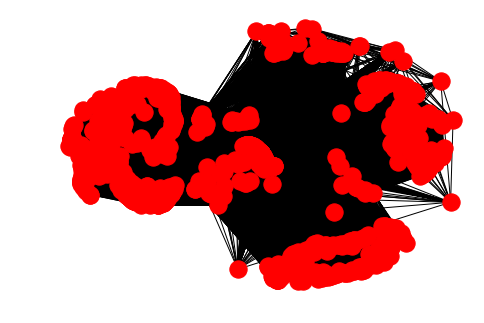

In [325]:
nx.draw(cc)

#### Island Method on Borough Nodes

In [290]:
pc = nx.bipartite.weighted_projected_graph(G, boro_nodes)
cc = list(nx.connected_component_subgraphs(pc))[0]
islands = island_method(cc, iterations = 4)

In [313]:
cc


C:\Users\15082\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


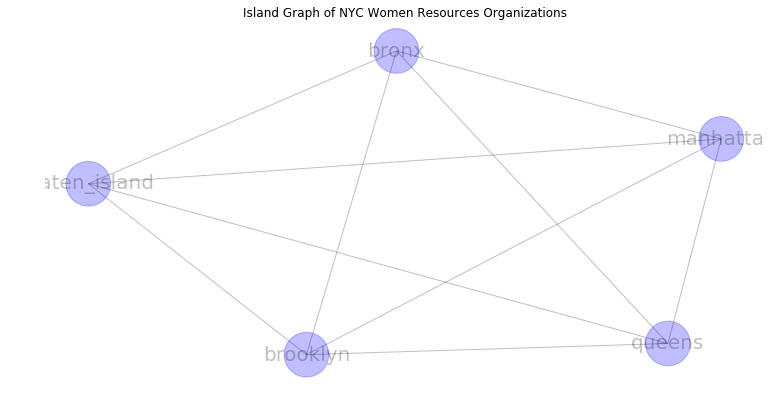

In [320]:
plt.figure(figsize=(10, 5))

pc = trim_edges(cc, 1)


for i in islands:
    c=i[0]
    l=len(i[1])
    s= len(list(nx.connected_component_subgraphs(i[1])))
    
nx.draw(cc, node_size=[v*500 for v in dict(d).values()], with_labels=True, node_color='b', alpha=.25, font_size=20)

plt.axis('off')
plt.title('Island Graph of NYC Women Resources Organizations')
plt.show()



In [294]:
dict(pc.degree(boro_nodes)).keys()

dict_keys(['bronx', 'queens', 'brooklyn', 'manhattan', 'staten_island'])

## Analysis 
+ What can you infer about each of the distinct groups?

## Video Presentation

Our recorded submission can be viewed in the embedded video player below: 

---
#### References

Social Network Analysis for Startups, Maksim Tsvetovat and Alexander Kouznetsov, O'Reilly, Sep 30, 201